In [10]:
from pyspark.sql import SparkSession
import os
from plotnine import *
import numpy as np

import pyspark.sql.functions as F

In [11]:
traces_location = "<directory_with_parquet_traces>"
list_of_workloads = list(map(lambda x: os.path.join(traces_location, x), os.listdir(traces_location)))

In [13]:
name_to_name_map = {
    "askalon_ee_": "Askalon Old 1",
    "askalon_ee2_": "Askalon Old 2",
    "Two_Sigma_pit": "Two Sigma 1",
    "Two_Sigma_dft": "Two Sigma 2",
    "LANL_Trinity": "LANL 1",
    "Google": "Google",
    "alibaba2018": "Alibaba"
}

In [14]:
spark = (SparkSession.builder
         .master("local[4]")
         .appName("Longitudinal Analysis")
         .config("spark.executor.memory", "8G")
         .config("spark.driver.memory", "2G")
         .getOrCreate())

In [15]:
def do_tasks_exist(workload_location):
    return "tasks" in os.listdir(workload_location)

def read_trace(workload_location):
    return spark.read.parquet(os.path.join(workload_location, "tasks", "schema-1.0"))

In [16]:
one_week_in_milliseconds = 1000*60*60*24*7

def is_trace_long_enough(tasks_df):
    # Exclude traces shorter than a week.
    max_timestamp = tasks_df.agg(F.max("ts_submit")).toPandas().loc[0, "max(ts_submit)"]
#     print(tasks_df.count())
#     print(max_timestamp)
    return max_timestamp >= one_week_in_milliseconds

In [17]:
one_hour_in_milliseconds = 1000*60*60
hours_in_a_day = 24

def get_tasks_per_hour_of_day(tasks_df):
    tasks_per_hour_df = tasks_df.groupby(F.floor(F.col("ts_submit") / F.lit(one_hour_in_milliseconds)).alias("hour")).count()
    tasks_per_hour_of_week = tasks_per_hour_df.groupby((F.col("hour") % hours_in_a_day).alias("hour_of_day")).agg(F.avg("count"))
    return tasks_per_hour_of_week

In [18]:
hist_df = None

for workload in list_of_workloads:
    if str(workload).endswith("py"): continue
    if not do_tasks_exist(workload):
        continue
    
    trace = read_trace(workload)
    
    if not is_trace_long_enough(trace):
        continue
        
    tasks_per_hour_of_week = get_tasks_per_hour_of_day(trace)
    
    workload_name = workload.split("/")[-1]
    
    if workload_name.startswith("askalon-new_ee68_"):
            continue
            
    if workload_name.startswith("OLD"):
            continue
    
    for start, full_name in name_to_name_map.items():
        if workload_name.startswith(start):
            workload_name = full_name
            break
    
    workload_df = tasks_per_hour_of_week.toPandas()
    workload_df["workload"] = workload_name
    
    if workload_name.startswith("Two"):
        workload_df = workload_df.sort_values("hour_of_day")
        workload_df["hour_of_day"] = np.roll(workload_df["hour_of_day"], -12)
    
    if hist_df is None:
        hist_df = workload_df
    else:
        hist_df = hist_df.append(workload_df)

/var/scratch/stalluri/miniconda3/envs/WTA/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/var/scratch/stalluri/miniconda3/envs/WTA/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ./plots/daily_trend.pdf
  warn('Filename: {}'.format(filename))


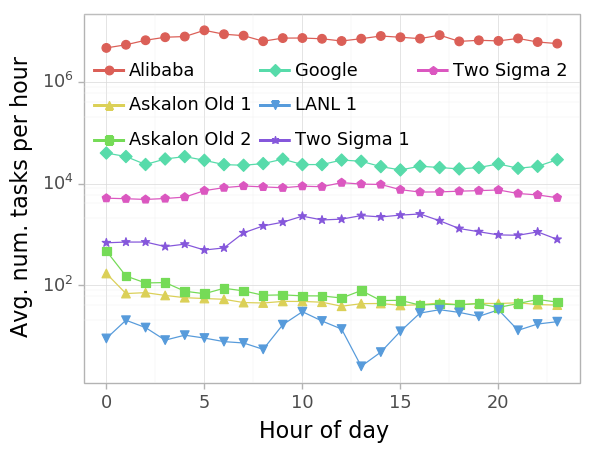

<ggplot: (-9223369104759731659)>

In [23]:
def formatYaxisLabels(xl):
    def format_e(n):
        a = '%E' % n
        return '$10^{' + a.split('E')[1][2:] + '}$'
    return list(map(lambda x: format_e(x), xl))

plt = ggplot(hist_df) +\
    theme_light(base_size=16) +\
    theme(legend_title=element_text(size=0, alpha=0),
                       legend_box_spacing=0.1,
                       legend_box_margin=0,
                       legend_margin=0,
          legend_position=(0.51, 0.7),
          legend_direction="horizontal",
          legend_key=element_blank(),
          legend_background=element_rect(fill=(0,0,0,0))) +\
    guides(color=guide_legend(ncol=3)) +\
    geom_line(aes(x="hour_of_day", y="avg(count)", group="workload", color="workload")) +\
    geom_point(aes(x="hour_of_day", y="avg(count)", shape="workload", color="workload"), size=3) +\
    scale_y_log10(labels=formatYaxisLabels) +\
    xlab("Hour of day") +\
    ylab("Avg. num. tasks per hour")

plt.save("./plots/daily_trend.pdf")
plt